# Building a video classification model Using Video Vision Transformers (ViViT)

Vision Transformers are a pure transformer based approach to image classification. Vision Transformer (ViT), which, when applied
directly to image patch sequences, can perform very well on image classification tasks.ViT also ensures the usage of significantly fewer computation resources to train.

Video Vision Transformer , ViViT is an extension of vision transformer, considering the fact that each video consists of several image frames.The fundamental computation performed in this architecture is self-attention. Furthermore, ViT can be utilized for real
time deployment due to it’s less computational efforts. This code implements the Spatio-temporal attention variant of the video vision transformer (ViViT) for the violence classification task. It aggregates Spatio-temporal tokens from the input video and encodes them using a network of transformer layers.

## Defining the data paths

In [ ]:
base_path = '/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset'
non_violence_path = base_path + '/NonViolence'
violence_path = base_path + '/Violence'

## Importing the necessary packages

In [ ]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import io  # Import the io module for input and output operations
import imageio  # Import the imageio library for working with images
import ipywidgets  # Import the ipywidgets library for creating interactive widgets
import tensorflow as tf  # Import the TensorFlow library for machine learning
from tensorflow import keras  # Import the Keras library from TensorFlow for neural network modeling
from tensorflow.keras import layers  # Import the layers module from Keras for building neural network layers
from keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from IPython.display import HTML, display
import time
from base64 import b64encode

import matplotlib.pyplot as plt
plt.style.use("seaborn")

%matplotlib inline

2024-02-29 14:25:35.717856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 14:25:35.717969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 14:25:36.014731: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_34/3273527333.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


## Viewing a sample of the data

In [ ]:
# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list = os.listdir(non_violence_path)
Violence_files_names_list = os.listdir(violence_path)

# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

In [ ]:
# To Show a Video in Notebook
def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

## Creating a dataframe of all the file paths

In [ ]:
#filepaths of violence videos
nv_data_paths = pd.DataFrame({
    'file_path': [os.path.join(base_path, 'NonViolence', filename) for filename in NonViolence_files_names_list],
    'label': 0
})


In [ ]:
nv_data_paths.head()

,file_path,label
0,/kaggle/input/real-life-violence-situations-da...,0
1,/kaggle/input/real-life-violence-situations-da...,0
2,/kaggle/input/real-life-violence-situations-da...,0
3,/kaggle/input/real-life-violence-situations-da...,0
4,/kaggle/input/real-life-violence-situations-da...,0


In [ ]:
#file paths of non violence videos
v_data_paths = pd.DataFrame({
    'file_path': [os.path.join(base_path, 'Violence', filename) for filename in Violence_files_names_list],
    'label': 1
})

In [ ]:
# combining them into a single dataframe
data_paths = pd.concat([nv_data_paths, v_data_paths], ignore_index=True)


In [ ]:
data_paths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  2000 non-null   object
 1   label      2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [ ]:
#dividing the data_paths into training and testing data using sklearn; ensuring that that there is no class imbalance by stratifying it along the y labels
# since the transformer model is data hungry, only 10% of the data is kept for testing

X_train, X_test, y_train, y_test = train_test_split(
    data_paths['file_path'],
    data_paths['label'],
    test_size=0.1,
    stratify=data_paths['label'],
    random_state=12345
)


## Hyperparameters for the model architecture and training

In [ ]:
# Setting seed for reproducibility
SEED = 42  # Set a seed value for random number generation for reproducibility
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"  # Configure TensorFlow for deterministic behavior

keras.utils.set_random_seed(SEED)  # Set the random seed for Keras operations


# DATA
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (16, 64, 64, 3)
NUM_CLASSES = 2
SEQUENCE_LENGTH = 16
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# OPTIMIZER
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

# TRAINING
EPOCHS = 100

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 16
NUM_LAYERS = 16

## Function to extract frames from each video based on the sequence length - here, 16 frames are extracted from each video

In [ ]:
def frames_extraction(video_path):

    frames_list = []

    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)


    video_reader.release()

    return frames_list

In [ ]:
#function to create a progress bar while fetching data
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


def create_dataset(files_list):
    '''
    Input: list of filepaths
    Output: numpy array of each frame in the video
    '''
    max = len(files_list)
    out = display(progress(0, max), display_id=True)

    features = []

    # Iterate through all the files present in the files list.
    for i, file_name in enumerate(files_list):
        # Extract the frames of the video file.
        frames = frames_extraction(file_name)
        # Chek if the extracted frames are equal to the SEQUENCE_LENGTH specified.
        # So ignore the vides having frames less than the SEQUENCE_LENGTH.
        if len(frames) == SEQUENCE_LENGTH:

          # Append the data to their repective lists.
          features.append(frames)


        out.update(progress(i, max))
    features = np.asarray(features)

    return features

## Prefetching the data

In [ ]:
train_videos = create_dataset(np.array(X_train))

In [ ]:
train_videos.shape

(1800, 16, 64, 64, 3)

In [ ]:
test_videos = create_dataset(np.array(X_test))

In [ ]:
np.save("train_videos_with_ten_percent_testing.npy",train_videos)

In [ ]:
np.save("test_videos_10percent.npy",test_videos)

In [ ]:
train_labels = np.array(y_train)
test_labels = np.array(y_test)

In [ ]:
@tf.function
def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels."""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )
    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare the dataloader."""

    labels = to_categorical(labels)
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    return dataloader,labels



In [ ]:
trainloader,train_labels = prepare_dataloader(train_videos, train_labels, "train")
# validloader = prepare_dataloader(valid_videos, valid_labels, "valid")
testloader,test_labels = prepare_dataloader(test_videos, test_labels, "test")

## Defining the model architecture:
### Tubelet Embeddings
![image.png](https://drive.google.com/uc?export=view&id=1osNwOPdfPU4Cyl_pXqvhEgDLMpzXmrx2)

Non-overlapping, spatiotemporal tubes of the
input sequences are retrieved from the video frames. These
volumes of sequences include both temporal as well as framespecific patches. The obtained volume of patches are then
linearly flattened to build several video encoded tokens. For a
tubelet with dimension t × w × h, \
![image.png](https://drive.google.com/uc?export=view&id=1XqClRAG4lJ9ksZht9WoTRpd4lO0o0Hkz) \
encoded tokens are retrieved from the temporal, width and
height dimensions respectively. This method, intuitively, integrates
spatio-temporal information during tokenisation.

In [ ]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches


## ViVit Model Architecture
![image.png](https://drive.google.com/uc?export=view&id=1baAprV6FgmAJpOyiT7wdgFXC3Vm9j-HV)


Since the transformer’s succeeding self-attention procedures are permutation invariant, a learned positional embedding, is also appended
to the tokens to maintain track of their positional information.

### The GELU Activation Function
![image.png](https://drive.google.com/uc?export=view&id=1atFW_pzwg-lVUtl4s66A2dSNcUVGdK6i) \

This function is differentiable at all points (as opposed to ReLU) and thus prevents gradients from becoming 0.

In [ ]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens


In [ ]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Define the input layer for the model
    inputs = layers.Input(shape=input_shape)

    # Create patches from the input data using the tubelet_embedder
    patches = tubelet_embedder(inputs)

    # Encode the patches using positional_encoder
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization and Multi-Head Self-Attention (MHSA)
        #dropout changed to 0.5
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.5
        )(x1, x1)

        # Add a skip connection to the output of MHSA
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and Multi-Layer Perceptron (MLP)
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Add another skip connection, connecting to the output of the MLP
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify the outputs using a dense layer with softmax activation
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model, connecting the input and output layers
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model


# Training the model

In [ ]:
def run_experiment():
    tf.keras.utils.register_keras_serializable('TubeletEmbedding', TubeletEmbedding)
    tf.keras.utils.register_keras_serializable('PositionalEncoder', PositionalEncoder)

    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=["accuracy"],
    )

    filepath="best_model_0.5_dropout_16_layers.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode = 'auto')


    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=20, restore_best_weights=True)
    my_callbacks = [checkpoint]

    # Train the model.
    history = model.fit(trainloader,validation_data = testloader, epochs=EPOCHS, callbacks = my_callbacks)

    _, accuracy = model.evaluate(testloader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model, history


model, history = run_experiment()

Epoch 1/100


I0000 00:00:1709218223.514653    8182 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 [==============================] - ETA: 0s - loss: 0.7845 - accuracy: 0.5050
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model_0.5_dropout_16_layers.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 62s 233ms/step - loss: 0.7845 - accuracy: 0.5050 - val_loss: 0.6981 - val_accuracy: 0.5000
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.7078 - accuracy: 0.4961
Epoch 2: val_accuracy did not improve from 0.50000
57/57 [==============================] - 10s 177ms/step - loss: 0.7078 - accuracy: 0.4961 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 3/100
57/57 [==============================] - ETA: 0s - loss: 0.7024 - accuracy: 0.4989
Epoch 3: val_accuracy improved from 0.50000 to 0.58500, saving model to best_model_0.5_dropout_16_layers.h5
57/57 [==============================] - 11s 190ms/step - loss: 0.7024 - accuracy: 0.4989 - val_loss: 0.6888 - val_accuracy: 0.5850
Epoch 4/100
57/57 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.5417
Epoch 4: val_accuracy improved from 0.58500 to 0.60000, saving model to best_model_0.5_dropout_16_layers.h5
57/57 [==============================] - 11s 192ms/s

## Visualising the Accuracy

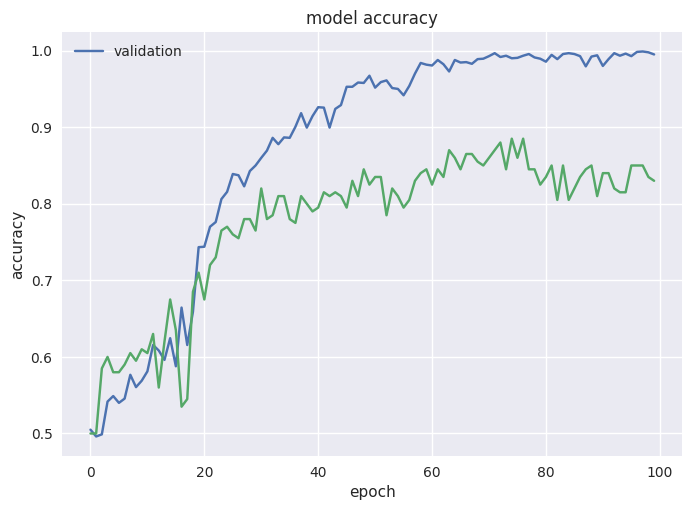

In [ ]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.legend(['validation'], loc='upper left')

plt.show()

In [ ]:
# Load the model with custom objects
with tf.keras.utils.custom_object_scope({
    'TubeletEmbedding': TubeletEmbedding,
    'PositionalEncoder': PositionalEncoder
}):
    loaded_model = tf.keras.models.load_model("/kaggle/working/best_model_0.5_dropout_16_layers.h5")
# model = keras.load_model
y_pred = loaded_model.predict(testloader)

7/7 [==============================] - 3s 67ms/step


## Classification Report

In [ ]:
y_pred_classes = [np.argmax(i) for i in y_pred]
test_labels_classes = [np.argmax(i) for i in test_labels]
print(classification_report(test_labels_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       100
           1       0.91      0.85      0.88       100

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.88       200
weighted avg       0.89      0.89      0.88       200



## Confusion Matrix

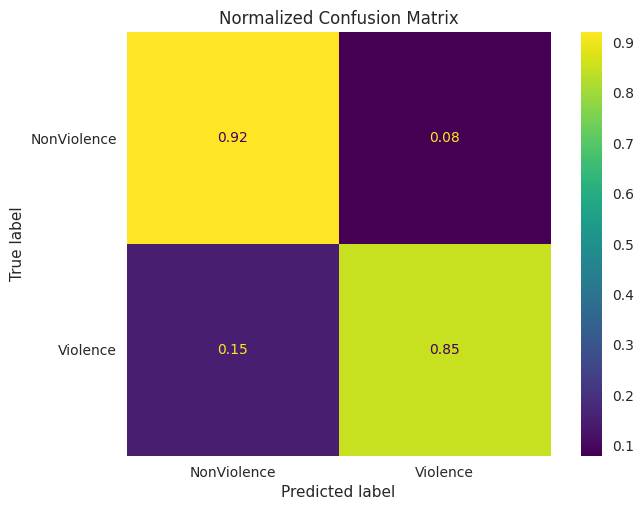

In [ ]:
cm = confusion_matrix(test_labels_classes, y_pred_classes, normalize='true')  # Compute normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NonViolence', 'Violence'])
disp.plot(values_format='.2f')  # Display percentages with 2 decimal places
plt.title('Normalized Confusion Matrix')  # Add a title to the plot
plt.grid(None)

plt.show()

## Results

The model has a precision of 86%, a recall of 92%, and an F1 Score of 89%.
The overall accuracy is 89%.

## Ways to improve the results:
 - Using data augmentation for videos: Since there are only 1000 videos per class and the duration of each video is short, we can employ data augmentation techniques such as Gaussian Blur, Random rotation, uniform perturbations and flipping in various directions.
 - Using a better regularization scheme for training.
 - Apply different variants of the transformer model: Here, we have used Spatio-temporal attention to capture both spatial and temporal features. We can also try to use Factorized encoder, Factorized self-attention, Factorized dot-product attention as detailed in the paper.
 - Hyperparameter Tuning: In this model, I have manually tuned the hyperparameters. We can apply more rigourous hyperparamter tuning methods like gridsearch to achieve the best possible paramters.
 - During the process of training, I could see that the model is often getting stuck in local minimas - this can be overcome by the use of evolutionary algorithms like genetic algorithms or particle swarm optimisation.

 ## References:
 - Arnab, Anurag, et al. "Vivit: A video vision transformer." Proceedings of the IEEE/CVF international conference on computer vision. 2021.

- Singh, Sanskar, et al. "Video vision transformers for violence detection." arXiv preprint arXiv:2209.03561 (2022).

